# BigData HF
A notebook a következőképpen épül fel:
Az elején a feladat lényegi részét mutatjuk be. A végén feltüntetjük a kísérleti adatelemzés részt, valamint a specifikáció félreértése miatt végrehajtott műveleteket. A konzultáció során pontosított feladat az első részben található. Ez alapján arra a kérdésre keressük a választ, hogy mennyire hagyhatóak el útvonalak a BKK éjszakai járatai közül úgy, hogy még mindig el lehessen jutni bárhova (azaz összefüggő legyen a hálózat).

## Install
https://bkk.hu/apps/gtfs/  
Az itt letöltehtő zip-ben lévő .csv-ket kell a `data` mappába kicsomagolni.

## Adatok betöltése, értelmezése (a notebook végén - EDA szekció)
 1. Első lépésként kigyűjtöttük a BKK weboldalának felhasználásával (https://bkk.hu/menetrendek/#ejszakai), hogy mely járatok éjszakaiak.
 2. Ezt követően betöltöttük a megfelelő csv fájlokat (lásd EDA szekció).
 3. Mintavételeztük az egyes fájlok tartalmát (limit segítségével)
 4. Értelmeztük a táblák tartalmát, mit szeretne reprezentálni, felhasználva a https://developers.google.com/transit/gtfs/reference/ leírást. Érdekesség: az adatok szerint 1 nap 30 órából áll. Erre magyarázatot az említett honlapon találtunk.
 5. Megkerestük a kapcsolatokat az egyes fájlok között az idegen kulcsokat felhasználva: pl: routes - trips (route_id), stops - stop_times (stop_id) stb...
 6. Definiáltuk az éjszakai járatok fogalmát, amit későbbiekben használni fogunk: éjszakai járatnak számít a BKK szerint ÉS az érkezési ideje stop_times.arrival_time 24-nél nagyobb
 7. Diagramon ábrázoltuk az érkezési időket, melyről leolvasható, az éjszakai járatok mennyivel ritkábbak.

## Feladat lényegi részei

### Továbbiakban használt könyvtárak importálása

In [22]:
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions
from pyspark.sql.functions import col
from pyspark.sql.functions import udf, array
from pyspark.sql.functions import count
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from datashader.utils import lnglat_to_meters
import bokeh.plotting as bp
from bokeh.models.tiles import WMTSTileSource
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage
from datashader.utils import export_image
import colorcet as cc
import os
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import CARTODBPOSITRON


### Spark context létrehozása, Spark SQL használatához

In [2]:
sc = SparkContext(appName="BigData")
spark = SQLContext (sc)

### Dataframe-k beolvasása a txt fájlokból

In [3]:
agency = spark.read.option("header", True).option("sep", ",").csv("data/agency.txt") 
calendar_dates = spark.read.option("header", True).option("sep", ",").csv("data/calendar_dates.txt") 
feed_info = spark.read.option("header", True).option("sep", ",").csv("data/feed_info.txt") 
pathways = spark.read.option("header", True).option("sep", ",").csv("data/pathways.txt")
routes = spark.read.option("header", True).option("sep", ",").csv("data/routes.txt")
shapes = spark.read.option("header", True).option("sep", ",").csv("data/shapes.txt")
stop_times = spark.read.option("header", True).option("sep", ",").csv("data/stop_times.txt") #nagy
stops = spark.read.option("header", True).option("sep", ",").csv("data/stops.txt")
trips = spark.read.option("header", True).option("sep", ",").csv("data/trips.txt")

### Éjszakai járatok definiálása felhasználva a BKK weboldalát 
https://bkk.hu/menetrendek/#ejszakai

In [4]:
ejszakai = ['M2', 'M4', 'H5', 'H6', 'H8', 'H9',
            '6',
            '901', '907', '908', '909', '914', '914A',
            '916', '918', '922', '923', '930', '931',
            '934', '937', '938', '940', '941', '943',
            '948', '950', '950A', '956', '963', '964',
            '966', '968', '972', '972', '972B', '973',
            '979', '979A', '980', '990', '992', '994',
            '994', '996', '996A', '998', '999']

### Beolvasás tesztelése

In [5]:
agency.printSchema()

root
 |-- agency_id: string (nullable = true)
 |-- agency_name: string (nullable = true)
 |-- agency_url: string (nullable = true)
 |-- agency_timezone: string (nullable = true)
 |-- agency_lang: string (nullable = true)
 |-- agency_phone: string (nullable = true)



### Éjszakai útvonalak kiszűrése

In [6]:
ejszakai_routes = routes.filter(col("route_short_name").isin(ejszakai))
ejszakai_routes.limit(1).show()

+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|agency_id|route_id|route_short_name|route_long_name|route_type|          route_desc|route_color|route_text_color|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|      BKK|    3060|               6|           null|         0|Széll Kálmán tér ...|     FFD800|          000000|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+



### Menetrend érkezési idejének átváltása másodpercbe

In [20]:

convert_udf = udf(lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1]), IntegerType())

stop_times = stop_times.withColumn('arrival_time_new', convert_udf(stop_times.arrival_time))

stop_times.select("arrival_time", "arrival_time_new").limit(1).show()

#stop_times["arrival_time"] = stop_times["arrival_time"].apply(lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1]))

+------------+----------------+
|arrival_time|arrival_time_new|
+------------+----------------+
|    04:25:00|             265|
+------------+----------------+



### Éjszakai útvonal azonosítók kigyűjtése
Éjszakainak azt definiáljuk, aminek az érkezési ideje éjfél után történik. Ezeket egy listába kiszűrtük.

In [8]:
ejszakai_arrival_time_tripids = [x.trip_id for x in stop_times.filter(col("arrival_time_new") >= 24*60).select("trip_id").rdd.toLocalIterator()]
print(ejszakai_arrival_time_tripids)

['A92244226J', 'B032113103', 'B032113103', 'B032113103', 'B032113104', 'B032113104', 'B032113104', 'B032113104', 'B032113104', 'B032113104', 'B032113104', 'B032113104', 'B032113104', 'B032113104', 'B032113104', 'B03211389J', 'B03211435J', 'B03211499J', 'B03211499J', 'B03247197J', 'B03247197J', 'B03247677', 'B03247677', 'B44527248', 'B44527248', 'B44527248', 'B44527248', 'B44527250', 'B44527250', 'B44527250', 'B44527250', 'B44527250', 'B44527250', 'B494622', 'B494622', 'B494622', 'B494622', 'B494622', 'B494622', 'B494623', 'B494623', 'B494623', 'B494623', 'B494623', 'B494623', 'B494623', 'B494623', 'B494624', 'B494624', 'B494624', 'B494624', 'B494624', 'B494624', 'B494624', 'B494624', 'B494624', 'B494624', 'B494624', 'B494624', 'B494624', 'B494624', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494625', 'B494626', 'B494626', 'B494626', 'B494626', 'B494626',

### Éjszakai utak (trip) kiválasztása
1. Éjszakai útvonalak kigyűjtése a korábban definiált éjszakai_routeids lista felhasználásával
2. Éjszakai utak (trip) kigyűjtése, felhasználva a második kritériumot is: legyen éjfél után az érkezési ideje (erre azért volt szükség, mert pl a 6-os villamos nappal is jár, de azok az utak nekünk nem kellenek)

In [9]:
ejszakai_routeids = ejszakai_routes.select("route_id").rdd.flatMap(lambda x: x).collect()
ejszakai_trips_temp = trips.filter(col("route_id").isin(ejszakai_routeids))

ejszakai_trips = ejszakai_trips_temp.filter(col("trip_id").isin(ejszakai_arrival_time_tripids))
ejszakai_trips.show()

+--------+-----------+-----------------+--------------------+------------+--------------------+--------+---------------------+-------------+-------------+
|route_id|    trip_id|       service_id|       trip_headsign|direction_id|            block_id|shape_id|wheelchair_accessible|bikes_allowed|boarding_door|
+--------+-----------+-----------------+--------------------+------------+--------------------+--------+---------------------+-------------+-------------+
|    9160|    B494622|B49462K1HPSZZ-021|  Széll Kálmán tér M|           0| B49462K1HPSZZ-021_1|    GZ64|                    1|            2|            1|
|    9160|    B494623|B49462K1HPSZZ-021|              Uránia|           1| B49462K1HPSZZ-021_2|    GZ65|                    1|            2|            1|
|    9160|    B494624|B49462K1HPSZZ-021|  Széll Kálmán tér M|           0| B49462K1HPSZZ-021_2|    GZ64|                    1|            2|            1|
|    9160|    B494625|B49462K1HPSZZ-021|              Uránia|         

### Éjszakai útvonalakhoz tartozó útvonal pontok meghatározása

In [10]:
ejszakai_trips_per_shape = ejszakai_trips.groupby('shape_id').agg(count(col("route_id")))
ejszakai_trips_per_shape=ejszakai_trips_per_shape.withColumnRenamed("count(route_id)", "trip_count")
ejszakai_trips_per_shape.describe().show()
ejszakai_trip_ids = [x.shape_id for x in ejszakai_trips_per_shape.select("shape_id").collect()]

+-------+------------------+------------------+
|summary|          shape_id|        trip_count|
+-------+------------------+------------------+
|  count|               195|               195|
|   mean|1902.5714285714287|15.056410256410256|
| stddev|1486.7296164336515|15.005905965700324|
|    min|              1111|                 1|
|    max|              Z566|                81|
+-------+------------------+------------------+



### Függvény definiálása egy megadott útvonal törléséhez

In [ ]:
def deleteshape(shapeid):
    ejszakai_trips_per_shape_withdel = ejszakai_trips_per_shape.filter(col("shape_id") != shapeid)
    return shapes.join(ejszakai_trips_per_shape_withdel, on='shape_id')


### Adat előkészítése az ábrához

In [21]:
def split_df_by(df, byvar):
    df_parts = []
    for level, df_part in df.groupby(byvar):
        empty = pd.DataFrame([[level if colname == byvar else np.NaN for colname in df.columns]],
                             columns=df.columns)
        df_parts.append(df_part.append(empty))
    return pd.concat(df_parts) 

def make_data_for_plot(shapeid):
    shape_suruseg = deleteshape(shapeid)
    ejszakai_shape_suruseg_pandas = shape_suruseg.toPandas()
    ejszakai_shape_suruseg_pandas['coord_x'], ejszakai_shape_suruseg_pandas['coord_y'] = \
        lnglat_to_meters(np.asarray(list(ejszakai_shape_suruseg_pandas['shape_pt_lon']), dtype='float64'), np.asarray(list(ejszakai_shape_suruseg_pandas['shape_pt_lat']), dtype='float64'))
    return split_df_by(ejszakai_shape_suruseg_pandas, 'shape_id')

ejszakai_shapes = make_data_for_plot("Z566")
ejszakai_shapes.head()

shape_id shape_pt_sequence shape_pt_lat shape_pt_lon shape_dist_traveled  \
0     1111            100001    47.502885    19.135571                 0.0   
1     1111            100002    47.502843    19.135591                 2.0   
2     1111            100003    47.502754    19.134754                66.0   
3     1111            100004    47.502691    19.133931               128.0   
4     1111            100005    47.502674    19.133334               173.0   

   trip_count       coord_x       coord_y  
0        15.0  2.130162e+06  6.024548e+06  
1        15.0  2.130164e+06  6.024541e+06  
2        15.0  2.130071e+06  6.024526e+06  
3        15.0  2.129979e+06  6.024516e+06  
4        15.0  2.129913e+06  6.024513e+06

### Ábra elkészítése Bokeh-val
Az ábrán a BKK éjszakai járatai láthatóak. A vonalak a járatok útvonalait mutatják, a szín pedig a sűrűségüket. Minél világosabb egy szakasz annál több éjszakai járat érinti az adott részt. A színezés a járatok egész estére vonatkozó aggregációjából származik, vagyis minél sűrűbben jár egy adott járat annál világosabb a színe az útvonalának. Ezáltal egy szakasz sűrűsége akkor is nőhet ha több járat halad át rajta az este folyamán vagy csak kevés járat de az gyakran. Az ábra generálásánál megadható, hogy melyik járat ne szerepeljen rajta, amiből kiderül, hogy a teljes hálózathoz képest nem lehet elvenni úgy járatot, hogy minden szakasz elérhető maradjon.

In [23]:
bp.output_notebook()

x_range=(2.101e6, 2.155e6)
y_range=(5.994e6, 6.052e6)

if not os.path.exists('./img'):
    os.mkdir('./img')
    
p = bp.figure(tools='pan,wheel_zoom,reset',
              plot_width=int(900),
              plot_height=int(900),
              x_range=x_range,
              y_range=y_range)

p.axis.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

url = "https://cartodb-basemaps-b.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png"
tile_renderer = p.add_tile(WMTSTileSource(url=url))
tile_renderer.alpha = 1

def image_callback(x_range, y_range, w, h, color_fn=tf.shade):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.line(ejszakai_shapes, 'coord_x', 'coord_y', agg=ds.sum('trip_count'))
    image = tf.shade(agg, cmap=cc.fire, how='eq_hist')
    return image

export_image(image_callback(x_range=x_range, y_range=y_range, w=2000, h=2000), filename="BUD_schedule_fire", background='black')
InteractiveImage(p, image_callback)

Loading BokehJS ...

## EDA

Ebben a szekcióban bemutatjuk a feladat és adathalmaz értelmezése során megtett lépéseket, valamint a kezdeti próbálkozásokat, az általunk értelmezett feladat irányába.

A feladatba sokmindent lehetett "redundancia" alatt értelmezni. Mi úgy definiáltuk kezdetben, hogy arra keressük a kérdést, hogy két megadott útvonal között hányféleképpen tudunk eljutni. Ennek a kérdésnek a megválaszolához megtett lépések is itt szerepelnek.

### DataFrame-k mintavételezése az adatok megértése miatt

In [12]:
calendar_dates.limit(10).show()

+------------------+--------+--------------+
|        service_id|    date|exception_type|
+------------------+--------+--------------+
| A9113924SZKP-0011|20181224|             1|
|A92244EVVHPKP-0011|20181227|             1|
|A92244EVVHPKP-0011|20181228|             1|
|B03211EVVHPKM-0011|20181227|             1|
|B03211EVVHPKM-0011|20181228|             1|
|B03247EVVHPKM-0011|20181227|             1|
|B03247EVVHPKM-0011|20181228|             1|
|  B05716AHPKP-0011|20181110|             1|
|  B05716AHPKP-0011|20181112|             1|
|  B05716AHPKP-0011|20181113|             1|
+------------------+--------+--------------+



In [13]:
pathways.limit(10).show()

+-------------+------------+------------+----------+--------------+-------------------------+
|   pathway_id|pathway_type|from_stop_id|to_stop_id|traversal_time|wheelchair_traversal_time|
+-------------+------------+------------+----------+--------------+-------------------------+
|LM4KF1-LM4KFA|           3|      LM4KF1|    LM4KFA|            30|                       -1|
|LM4KF1-LM4KFB|           3|      LM4KF1|    LM4KFB|           150|                       -1|
|LM4KF1-LM4KFC|           3|      LM4KF1|    LM4KFC|           150|                       -1|
|LM4KF1-LM4KFD|           3|      LM4KF1|    LM4KFD|           180|                       -1|
|LM1OPV-F01079|           1|      LM1OPV|    F01079|            30|                       -1|
|LM1DF1-F00962|           1|      LM1DF1|    F00962|            30|                       -1|
|F01749-LM2OV1|           1|      F01749|    LM2OV1|            30|                       60|
|F00937-LM3NY1|           1|      F00937|    LM3NY1|        

In [16]:
routes.limit(10).show()

+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|agency_id|route_id|route_short_name|route_long_name|route_type|          route_desc|route_color|route_text_color|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|      BKK|    0050|               5|           null|         3|Pasaréti tér / Rá...|     009FE3|          FFFFFF|
|      BKK|    0070|               7|           null|         3|Albertfalva vasút...|     009FE3|          FFFFFF|
|      BKK|    0075|              7E|           null|         3|Blaha Lujza tér M...|     009FE3|          FFFFFF|
|      BKK|    0078|              7G|           null|         3|Cinkotai autóbusz...|     009FE3|          FFFFFF|
|      BKK|    0085|              8E|           null|         3|Kelenföld vasútál...|     009FE3|          FFFFFF|
|      BKK|    0090|               9|           null|         3|Óbuda, Bogdáni ú

In [17]:
routes[routes.route_short_name == "923"].limit(10).show()

+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|agency_id|route_id|route_short_name|route_long_name|route_type|          route_desc|route_color|route_text_color|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|      BKK|    9230|             923|           null|         3|Békásmegyer H / D...|     1E1E1E|          FFFFFF|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+



In [18]:
shapes.limit(100).show()

+--------+-----------------+------------+------------+-------------------+
|shape_id|shape_pt_sequence|shape_pt_lat|shape_pt_lon|shape_dist_traveled|
+--------+-----------------+------------+------------+-------------------+
|    0285|           100001|   47.519630|   19.148313|                0.0|
|    0285|           100002|   47.519657|   19.148286|                4.0|
|    0285|           100003|   47.519839|   19.148638|               35.0|
|    0285|           100004|   47.520584|   19.150246|              182.0|
|    0285|           100005|   47.520674|   19.150432|              199.0|
|    0285|           100006|   47.520727|   19.150486|              206.0|
|    0285|           100007|   47.520790|   19.150512|              213.0|
|    0285|           100008|   47.520988|   19.150964|              253.0|
|    0285|           100009|   47.521320|   19.151695|              319.0|
|    0285|           100010|   47.521543|   19.152207|              367.0|
|    0285|           1000

In [19]:
stop_times.limit(100).show()

+---------+-------+------------+--------------+-------------+-------------+-----------+-------------+-------------------+----------------+
|  trip_id|stop_id|arrival_time|departure_time|stop_sequence|stop_headsign|pickup_type|drop_off_type|shape_dist_traveled|arrival_time_new|
+---------+-------+------------+--------------+-------------+-------------+-----------+-------------+-------------------+----------------+
|  A911391| F04272|    04:25:00|      04:25:00|            0|         null|       null|         null|                0.0|             265|
|  A911391| F04184|    04:27:00|      04:27:00|            1|         null|       null|         null|              648.0|             267|
|  A911391| F04319|    04:29:00|      04:29:00|            2|         null|       null|         null|             1224.0|             269|
|  A911391| F04369|    04:32:00|      04:32:00|            3|         null|       null|         null|             2779.0|             272|
|  A911391| 008264|    04:3

In [20]:
stop_times.filter(stop_times.stop_id == "F04272").limit(10).show()

+---------+-------+------------+--------------+-------------+-------------+-----------+-------------+-------------------+----------------+
|  trip_id|stop_id|arrival_time|departure_time|stop_sequence|stop_headsign|pickup_type|drop_off_type|shape_dist_traveled|arrival_time_new|
+---------+-------+------------+--------------+-------------+-------------+-----------+-------------+-------------------+----------------+
|  A911391| F04272|    04:25:00|      04:25:00|            0|         null|       null|         null|                0.0|             265|
| A9113910| F04272|    07:34:00|      07:34:00|            5|         null|       null|         null|             6690.0|             454|
|A91139100| F04272|    14:01:00|      14:01:00|            5|         null|       null|         null|             6690.0|             841|
|A91139101| F04272|    14:08:00|      14:08:00|            0|         null|       null|         null|                0.0|             848|
|A91139102| F04272|    14:4

In [21]:
stops.limit(10).show()

+-------+--------------------+---------+---------+---------+-------------+--------------+-------------------+--------------+
|stop_id|           stop_name| stop_lat| stop_lon|stop_code|location_type|parent_station|wheelchair_boarding|stop_direction|
+-------+--------------------+---------+---------+---------+-------------+--------------+-------------------+--------------+
| 002133|Örs vezér tere M+...|47.500366|19.135700|     null|         null|          null|                  2|          null|
| 002136|   Fogas üzem (kapu)|47.509119|19.014403|     null|         null|          null|               null|          null|
| 002138|Kőbánya alsó vasú...|47.483139|19.127891|     null|         null|          null|                  2|          null|
| 003002|Puskás Ferenc Sta...|47.500368|19.103406|     null|         null|          null|                  2|          null|
| 003105|Bécsi út / Vörösv...|47.548817|19.029722|     null|         null|          null|                  2|          null|


In [24]:
trips.select("route_id", "trip_id", "trip_headsign").limit(10).show()

+--------+---------+-------------+
|route_id|  trip_id|trip_headsign|
+--------+---------+-------------+
|    6300|  A911391|Boráros tér H|
|    6300| A9113910|       Csepel|
|    6300|A91139100|       Csepel|
|    6300|A91139101|Boráros tér H|
|    6300|A91139102|       Csepel|
|    6300|A91139103|Boráros tér H|
|    6300|A91139104|       Csepel|
|    6300|A91139105|Boráros tér H|
|    6300|A91139106|       Csepel|
|    6300|A91139108|Boráros tér H|
+--------+---------+-------------+



In [23]:
trips.count()

284187

In [24]:
stops.describe()

DataFrame[summary: string, stop_id: string, stop_name: string, stop_lat: string, stop_lon: string, stop_code: string, location_type: string, parent_station: string, wheelchair_boarding: string, stop_direction: string]

### Járatok gyakorisága óránként
Mintavételezést követően megnéztük, hogy néznek ki a járatok, órákra lebontva. Ezzel észrevettük, hogy egy nap nem 24, hanem 29 órából áll. Erre magyarázatot a https://developers.google.com/transit/gtfs/reference/ weboldalon találtunk. Így definiáltuk az éjszakai járatokat, éjfél utána (24 óra utáni) járatoknak. Ez a rész pandasban íródott még.

In [28]:
stop_times_pandas = pd.read_csv('data/'+'stop_times.txt') 


/Users/barnabasmaidics/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
def intdate(n):
    arr = n.split(':')
    return int(arr[0])*60*60+int(arr[1])*60+int(arr[2])

In [30]:
ll = list(map(intdate, stop_times_pandas['arrival_time']))

/Users/barnabasmaidics/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0.0, 39240.0)

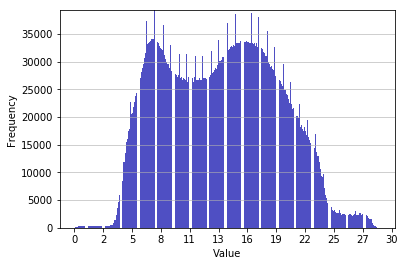

In [31]:
fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=ll, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
def price(x, n):
    ora = x//(60*60)
    return int(ora)
ax.xaxis.set_major_locator(plt.MaxNLocator(12))

ax.xaxis.set_major_formatter(plt.FuncFormatter(price))

maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [32]:
max(ll)//(60*60)

29

### Vakvágány (félreértelmezett feladat)
Első értelmezésre arra kerestük a választ, hogy két megálló között hányféleképpen tudunk eljutni egy megadott időintervallumban. Ehhez megszereztük egy adott megállónévhez tartozó stop_id-kat, majd azokat a járműveket akartuk kiválasztani, amik megállnak ezeken a megállókon. Így tudjuk az átszállásokat kezelni. Ebben a táblában duplikáltan szerepelnek az értékek, így szűrés szükséges még.

In [80]:

#Egy megallonevhez tartozo megallok
stop_ids = stops.filter(col("stop_name").like("%Harminckettesek%")).select("stop_id").rdd.flatMap(lambda x: x).collect()

#A stop_ids helyen megálló járművek (a hét minden napja benne van még)
stops_week = stop_times.filter(col("stop_id").isin(stop_ids)).select("trip_id", "stop_id", "arrival_time").sort("arrival_time")

stops_week.show()

+------------+-------+------------+
|     trip_id|stop_id|arrival_time|
+------------+-------+------------+
| B6621147801| F01199|    00:13:00|
| B7752255127| F01199|    00:13:00|
| B6626647801| F01199|    00:13:00|
| B8745455127| F01199|    00:13:00|
|B76861114960| F01199|    00:13:00|
| B7749641585| F01199|    00:13:00|
|B87463114960| F01199|    00:13:00|
|B89263114960| F01199|    00:13:00|
| B8776941585| F01199|    00:13:00|
| B8781832740| F01199|    00:13:00|
| B7752755127| F01199|    00:13:00|
| B7898832740| F01199|    00:13:00|
|B86108114960| F01199|    00:13:00|
| B8776941591| F01199|    00:23:00|
| B7749641591| F01199|    00:23:00|
| B7898832752| F01199|    00:23:00|
| B8781832752| F01199|    00:23:00|
| B8776934682| F01197|    00:24:00|
| B7749634682| F01197|    00:24:00|
| B8781826517| F01197|    00:24:00|
+------------+-------+------------+
only showing top 20 rows



Szelektáltuk az éjszakai útvonalak, majd kiválasztottunk egy napot a service_id-t felhasználva. GDFS specifikáció szerint: "The service_id contains an ID that uniquely identifies a set of dates when service is available for one or more routes". Így megkaptuk az egy napra vonatkozó éjszakai menetrendeket, az egyes trip_id-kal. Ebből és az előző stop_weeks táblából szerettünk volna kiindulni, hogy megkapjuk a kérdésre a választ: két állomás között egy adott időintervallumban hányféleképpen tudunk eljutni. 

In [81]:

ejszakai_routes_list = routes.filter(col("route_short_name").isin(ejszakai)).rdd.flatMap(lambda x: x).collect()

ejszakai_trips = trips.filter(col("route_id").isin(ejszakai_routes_list))

service_id = stops_week.limit(1).select("trip_id").join(ejszakai_trips, "trip_id").select("service_id")

service_id.join(trips, "service_id").join(stops_week, "trip_id").select("trip_id", "stop_id", "arrival_time").sort("arrival_time").show()

+-----------+-------+------------+
|    trip_id|stop_id|arrival_time|
+-----------+-------+------------+
|B6621147801| F01199|    00:13:00|
|B6621147795| F01199|    00:33:00|
|B6621132695| F01197|    00:34:00|
|B6621132692| F01199|    00:43:00|
|B6621132701| F01197|    00:44:00|
|B6621132707| F01197|    00:54:00|
|B6621132698| F01199|    01:03:00|
|B6621132713| F01197|    01:04:00|
|B6621132704| F01199|    01:13:00|
|B6621132710| F01199|    01:23:00|
|B6621132719| F01197|    01:24:00|
|B6621132725| F01197|    01:34:00|
|B6621132716| F01199|    01:38:00|
|B6621132722| F01199|    01:53:00|
|B6621132731| F01197|    01:54:00|
|B6621132737| F01197|    02:04:00|
|B6621132728| F01199|    02:08:00|
|B6621132743| F01197|    02:19:00|
|B6621132734| F01199|    02:23:00|
|B6621132749| F01197|    02:34:00|
+-----------+-------+------------+
only showing top 20 rows



Próbálkoztunk még OpenStreetMap-es interaktív térképen vizualizálni, azonban ekkor jött a feladat pontosítása, így eldobtuk ezt a szálat

In [33]:

output_file("tile.html")

# range bounds supplied in web mercator coordinates
p = figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

show(p)